In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# Load the JSON file into a DataFrame, specifying lines=True
combined_lysin_b_df = pd.read_json('combined_lysin_b_df.json', lines=True)

In [3]:
combined_lysin_b_df.head()

,GeneID,phams,Name,translation,PhageID,HostStrain,Cluster,LysinType,Molecular_Weight,Aromaticity,...,Hydrophobicity_Score,Molecular_Weight_Score,Protein_Length_Score,Hamming_Distance_Score,Stability_Score,Size_Score,Similarity_Score,Treatment_Score,HostStrain_Encoded,Cluster_Encoded
0,20ES_CDS_10,152741,20ES,MSLQVGSSGELVNRWIRVMKARFASYAGKLKEDGYFGLDDKAVQQE...,20ES,Mycobacterium,A2,lysin_B,36578.3514,0.107692,...,0.229470,0.467192,0.535849,0.588983,0.452610,0.501521,0.588983,0.443146,1,7
1,32HC_CDS_37,3452,32HC,MAWKQPQLTDPPMVSEEIGKLNRRLLLAYAANSRAVEAGVQLHDVF...,32HC,Mycobacterium,Z,lysin_B,41216.7621,0.091384,...,0.724050,0.302072,0.316981,0.309322,0.420340,0.309526,0.309322,0.440810,1,144
2,39HC_CDS_42,152741,39HC,MSLALGSSGLMAAAWAAMMRLRFPGYALGRDGKPLGVDGYFGYDEE...,39HC,Mycobacterium,B6,lysin_B,35566.7986,0.084592,...,0.277975,0.503202,0.513208,0.550847,0.438805,0.508205,0.550847,0.443958,1,28
3,40AC_CDS_14,152741,40AC,MSLTLGSQGEIVNRWIRVMKARFVSYAGKLREDAYFGLDDAEVQKE...,40AC,Mycobacterium,A17,lysin_B,36595.5658,0.104615,...,0.300990,0.466580,0.535849,0.588983,0.478955,0.501214,0.588983,0.467536,1,5
4,40BC_CDS_42,152741,40BC,MSLALGSSGLMAAAWAAMMRLRFPGYALGRDGKPLGVDGYFGYDEE...,40BC,Mycobacterium,B6,lysin_B,35566.7986,0.084592,...,0.277975,0.503202,0.513208,0.550847,0.438805,0.508205,0.550847,0.443958,1,28


In [4]:
# Check shape of df
combined_lysin_b_df.shape

(2502, 31)

In [5]:
# Check data types of df
combined_lysin_b_df.dtypes

GeneID                      object
phams                        int64
Name                        object
translation                 object
PhageID                     object
HostStrain                  object
Cluster                     object
LysinType                   object
Molecular_Weight           float64
Aromaticity                float64
Instability_Index          float64
Gravy                      float64
Isoelectric_Point          float64
Aliphatic_Index            float64
Hydrophobicity             float64
Protein_Length               int64
Hamming_Distance             int64
Instability_Index_Score    float64
Isoelectric_Point_Score    float64
Aliphatic_Index_Score      float64
Gravy_Score                float64
Hydrophobicity_Score       float64
Molecular_Weight_Score     float64
Protein_Length_Score       float64
Hamming_Distance_Score     float64
Stability_Score            float64
Size_Score                 float64
Similarity_Score           float64
Treatment_Score     

In [6]:
# Check df for missing values
combined_lysin_b_df.isnull().sum()

GeneID                     0
phams                      0
Name                       0
translation                0
PhageID                    0
HostStrain                 0
Cluster                    0
LysinType                  0
Molecular_Weight           0
Aromaticity                0
Instability_Index          0
Gravy                      0
Isoelectric_Point          0
Aliphatic_Index            0
Hydrophobicity             0
Protein_Length             0
Hamming_Distance           0
Instability_Index_Score    0
Isoelectric_Point_Score    0
Aliphatic_Index_Score      0
Gravy_Score                0
Hydrophobicity_Score       0
Molecular_Weight_Score     0
Protein_Length_Score       0
Hamming_Distance_Score     0
Stability_Score            0
Size_Score                 0
Similarity_Score           0
Treatment_Score            0
HostStrain_Encoded         0
Cluster_Encoded            0
dtype: int64

In [7]:
# Confirm unique values in GeneID
combined_lysin_b_df['GeneID'].duplicated().sum()

0

In [8]:
# Summary stats of df
combined_lysin_b_df.describe()

,phams,Molecular_Weight,Aromaticity,Instability_Index,Gravy,Isoelectric_Point,Aliphatic_Index,Hydrophobicity,Protein_Length,Hamming_Distance,...,Hydrophobicity_Score,Molecular_Weight_Score,Protein_Length_Score,Hamming_Distance_Score,Stability_Score,Size_Score,Similarity_Score,Treatment_Score,HostStrain_Encoded,Cluster_Encoded
count,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,...,2502.000000,2502.000000,2502.000000,2.502000e+03,2502.000000,2502.000000,2.502000e+03,2502.000000,2502.000000,2502.000000
mean,146681.318945,35184.263601,0.092105,34.591262,-0.161509,6.629431,85.000522,-0.161509,323.715028,283.675060,...,0.464695,0.516820,0.540698,5.903599e-01,0.467508,0.528759,5.903599e-01,0.512830,0.787370,57.523981
std,28885.561058,6276.878948,0.011762,6.320897,0.190654,1.365119,7.181747,0.190654,63.448026,48.126627,...,0.271875,0.223448,0.239427,2.039264e-01,0.121623,0.230942,2.039264e-01,0.120687,0.418906,44.825425
min,1116.000000,21611.236100,0.058419,16.612500,-0.487379,4.474843,65.454545,-0.487379,202.000000,187.000000,...,0.000000,0.000000,0.000000,1.110223e-16,0.245660,0.000000,1.110223e-16,0.262663,0.000000,0.000000
25%,152179.000000,30829.628175,0.083333,30.743958,-0.318078,5.682956,79.298246,-0.318078,279.000000,251.000000,...,0.241425,0.424158,0.471698,5.127119e-01,0.355008,0.447928,5.127119e-01,0.417674,1.000000,20.000000
50%,152741.000000,35961.657700,0.093093,34.021472,-0.205096,6.058661,84.577114,-0.205096,323.000000,283.000000,...,0.402539,0.489146,0.543396,5.932203e-01,0.442470,0.517050,5.932203e-01,0.463819,1.000000,45.000000
75%,152741.000000,37787.245500,0.099415,39.262368,-0.026087,7.747433,91.875000,-0.026087,342.000000,302.000000,...,0.657808,0.671839,0.709434,7.288136e-01,0.548352,0.686952,7.288136e-01,0.629671,1.000000,100.000000
max,153741.000000,49702.271800,0.129693,56.210638,0.213877,9.977272,107.490347,0.213877,467.000000,423.000000,...,1.000000,1.000000,1.000000,1.000000e+00,0.879496,0.987814,1.000000e+00,0.831214,2.000000,144.000000


In [9]:
# Define a consistent color palette
custom_palette = sns.color_palette("mako", n_colors=3)

# Apply the custom palette globally (optional)
sns.set_palette(custom_palette)

HostStrain
Mycobacterium    1950
Gordonia          542
Rhodococcus        10
Name: count, dtype: int64


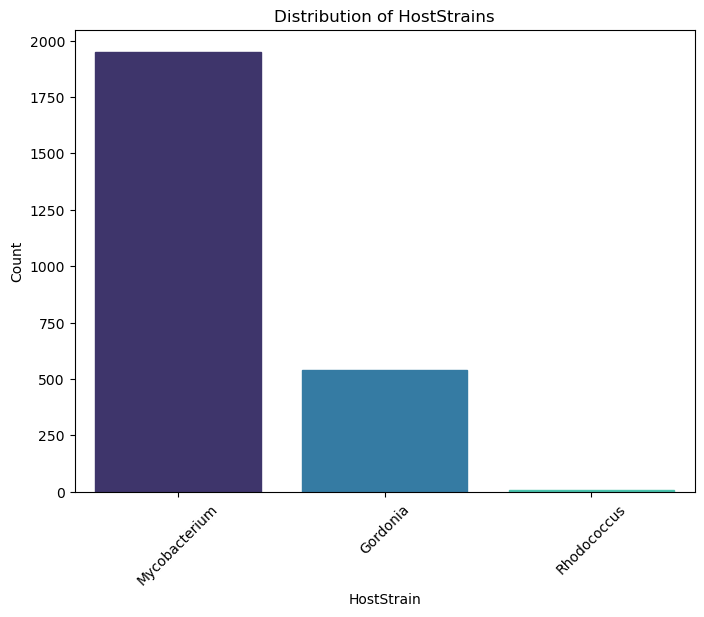

In [10]:
# Count the occurrences of each HostStrain
hoststrain_counts = combined_lysin_b_df['HostStrain'].value_counts()
print(hoststrain_counts)

# Create a bar plot for HostStrain distribution manually applying the custom palette
plt.figure(figsize=(8, 6))
bars = sns.barplot(x=hoststrain_counts.index, y=hoststrain_counts.values)

# Apply colors manually to each bar
for i, bar in enumerate(bars.patches):
    bar.set_color(custom_palette[i % len(custom_palette)])

plt.title('Distribution of HostStrains')
plt.xlabel('HostStrain')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

       HostStrain   phams  Count
0        Gordonia   85573      4
1        Gordonia  151630    514
2        Gordonia  152179     19
3        Gordonia  152925      1
4        Gordonia  153741      4
5   Mycobacterium    1116     72
6   Mycobacterium    3452     19
7   Mycobacterium   10267      4
8   Mycobacterium  152741   1424
9   Mycobacterium  152786    431
10    Rhodococcus  151630     10


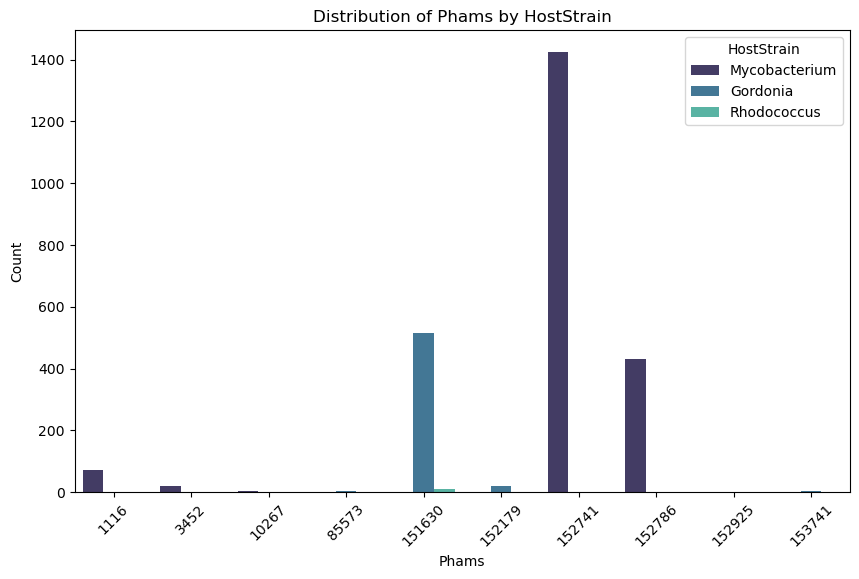

In [11]:
# Group by HostStrain and phams, then count the occurrences
phams_counts = combined_lysin_b_df.groupby(['HostStrain', 'phams']).size().reset_index(name='Count')
print(phams_counts)

# Sort the phams_counts by the phams number
phams_counts = phams_counts.sort_values(by='phams')

# Create a bar plot for phams by HostStrain using the adjusted palette
plt.figure(figsize=(10, 6))
sns.barplot(data=phams_counts, x='phams', y='Count', hue='HostStrain', order=phams_counts['phams'].unique(), palette=custom_palette)
plt.title('Distribution of Phams by HostStrain')
plt.xlabel('Phams')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='HostStrain')
plt.show()


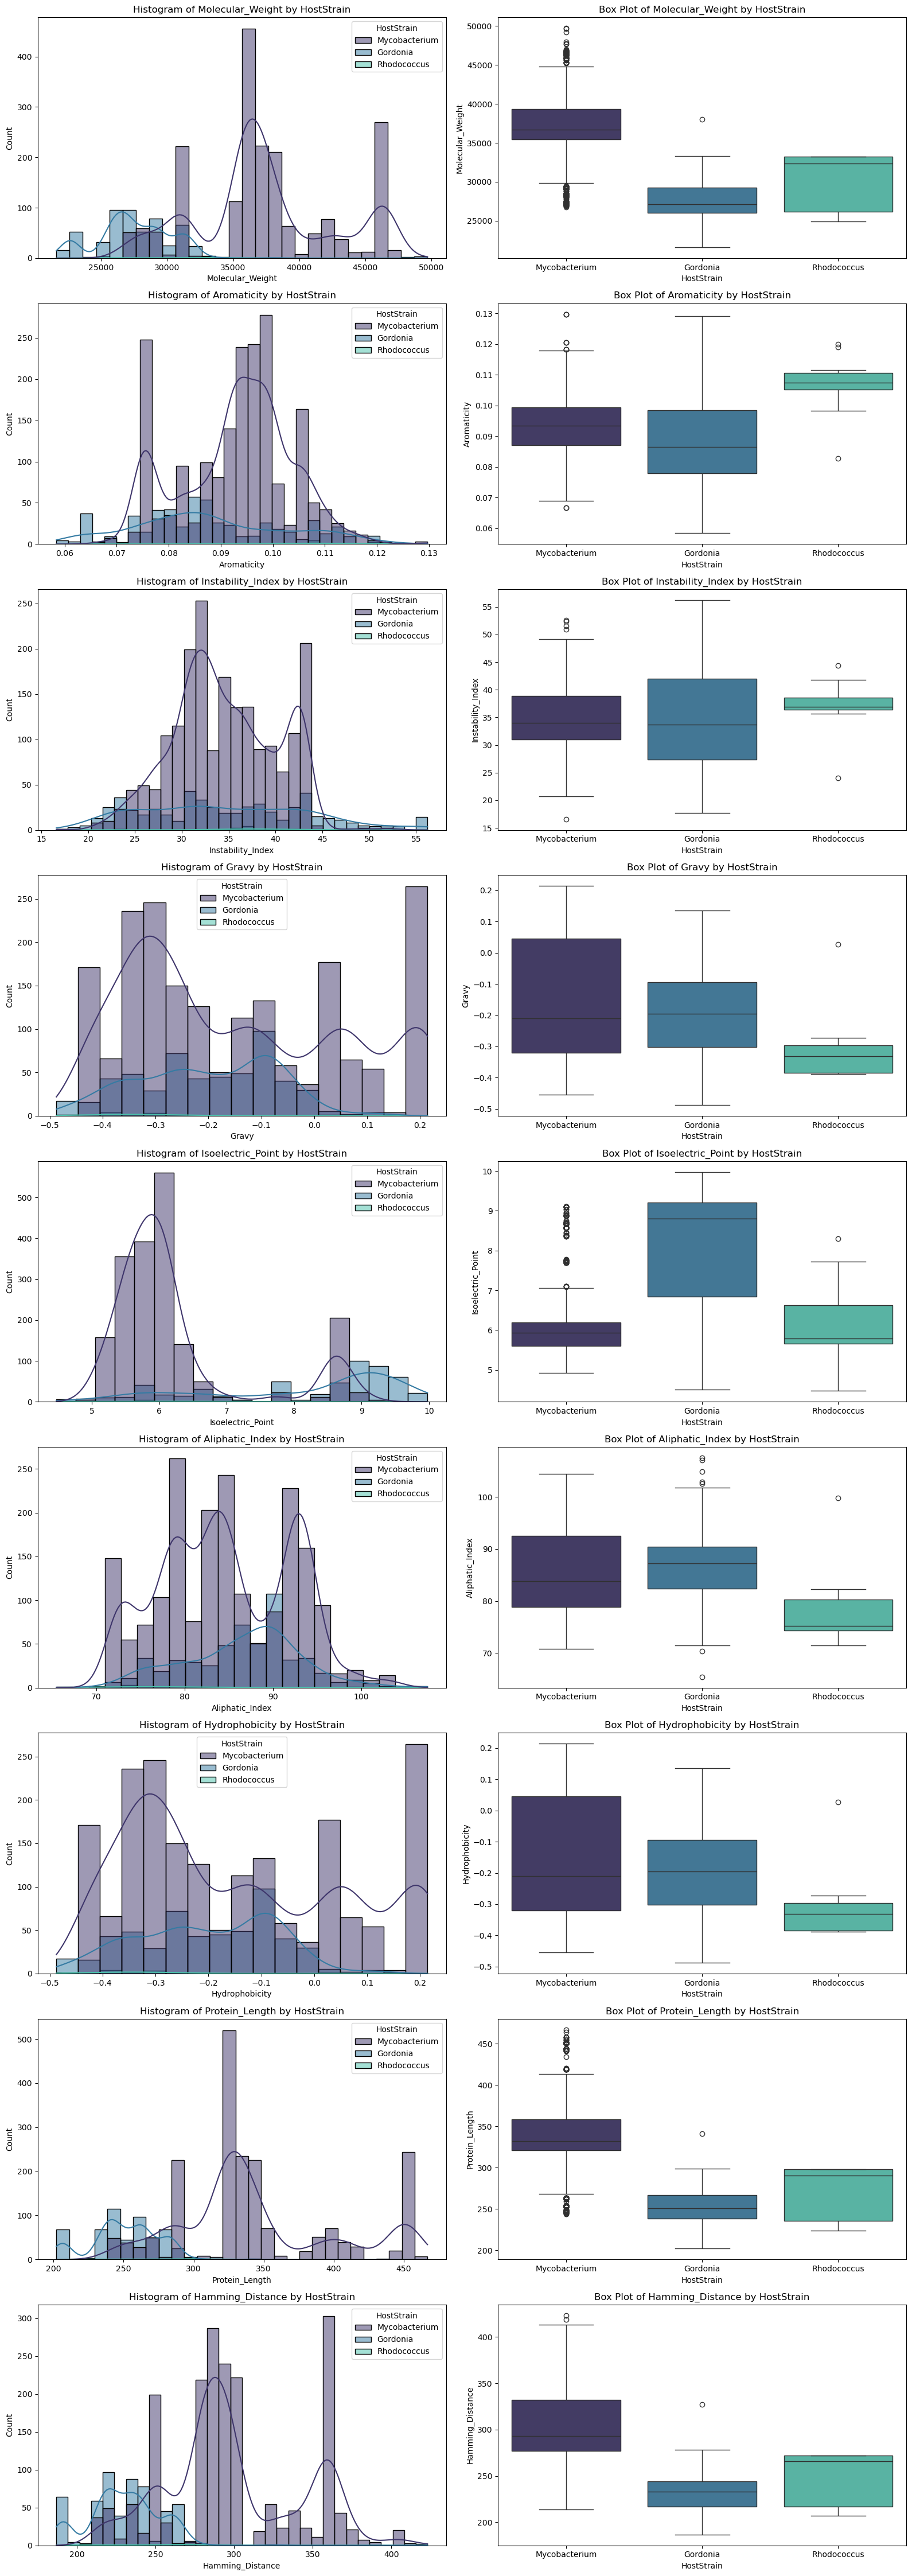

In [12]:
# List of features to plot histograms and boxplots
features = [
    'Molecular_Weight', 'Aromaticity', 'Instability_Index', 'Gravy', 
    'Isoelectric_Point', 'Aliphatic_Index', 'Hydrophobicity', 
    'Protein_Length', 'Hamming_Distance'
]

# Set up the plotting area
fig, axes = plt.subplots(nrows=len(features), ncols=2, figsize=(16, 5 * len(features)))

# Loop through each feature and create histograms and box plots grouped by HostStrain
for i, feature in enumerate(features):
    # Histogram
    sns.histplot(data=combined_lysin_b_df, x=feature, hue='HostStrain', kde=True, ax=axes[i, 0], palette=custom_palette)
    axes[i, 0].set_title(f'Histogram of {feature} by HostStrain')
    
    # Box plot using hue for color differentiation
    sns.boxplot(data=combined_lysin_b_df, x='HostStrain', y=feature, hue='HostStrain', ax=axes[i, 1], palette=custom_palette)
    axes[i, 1].set_title(f'Box Plot of {feature} by HostStrain')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

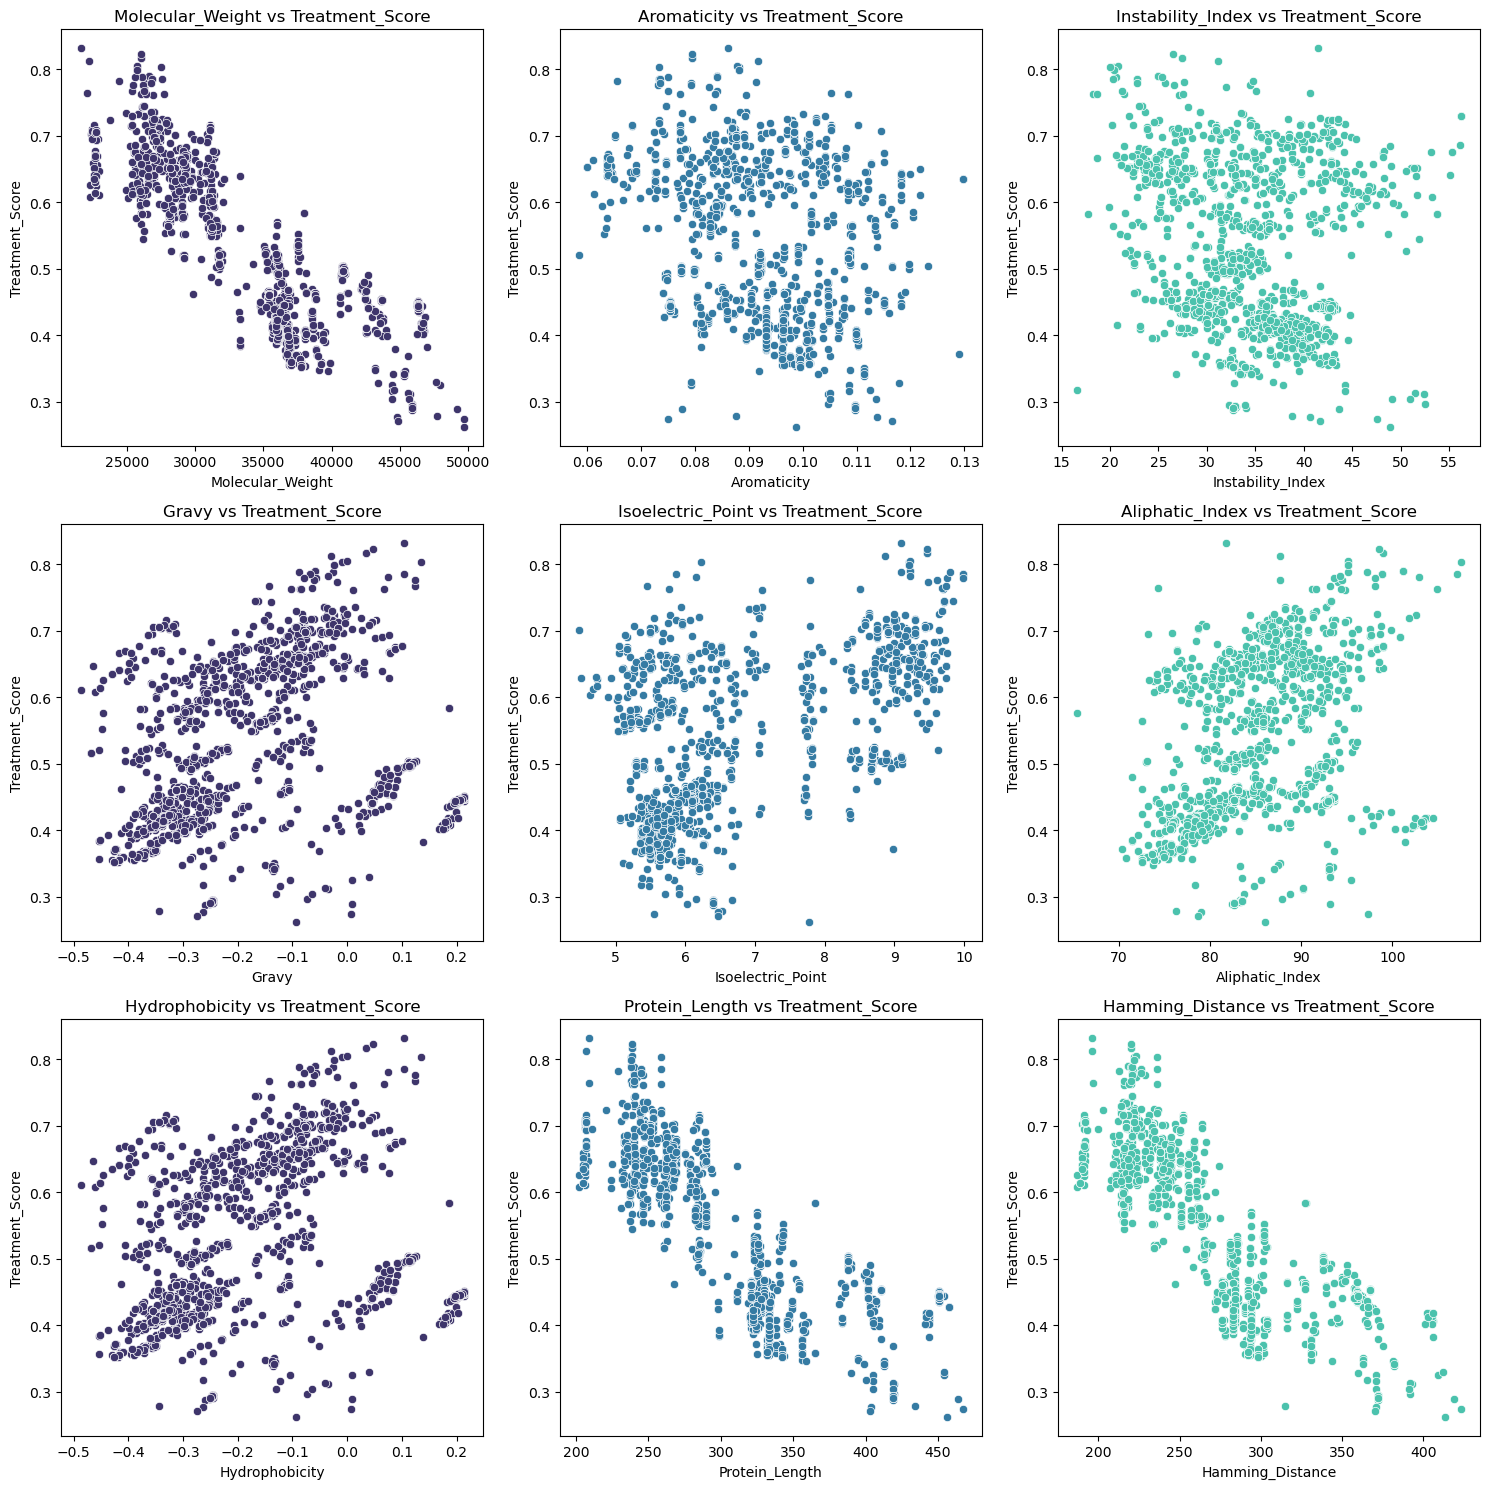

In [13]:
# List of features to plot against Treatment_Score
features = [
    'Molecular_Weight', 'Aromaticity', 'Instability_Index', 'Gravy', 
    'Isoelectric_Point', 'Aliphatic_Index', 'Hydrophobicity', 
    'Protein_Length', 'Hamming_Distance'
]

# Define the number of columns for your subplot layout
n_cols = 3
n_rows = len(features) // n_cols + (len(features) % n_cols > 0)

# Set up the plotting area
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten axes array for easy iteration

# Loop through each feature and create scatter plots vs Treatment_Score
for i, feature in enumerate(features):
    sns.scatterplot(
        data=combined_lysin_b_df, 
        x=feature, 
        y='Treatment_Score', 
        ax=axes[i], 
        color=custom_palette[i % len(custom_palette)]
    )
    axes[i].set_title(f'{feature} vs Treatment_Score')

# Hide any unused subplots
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

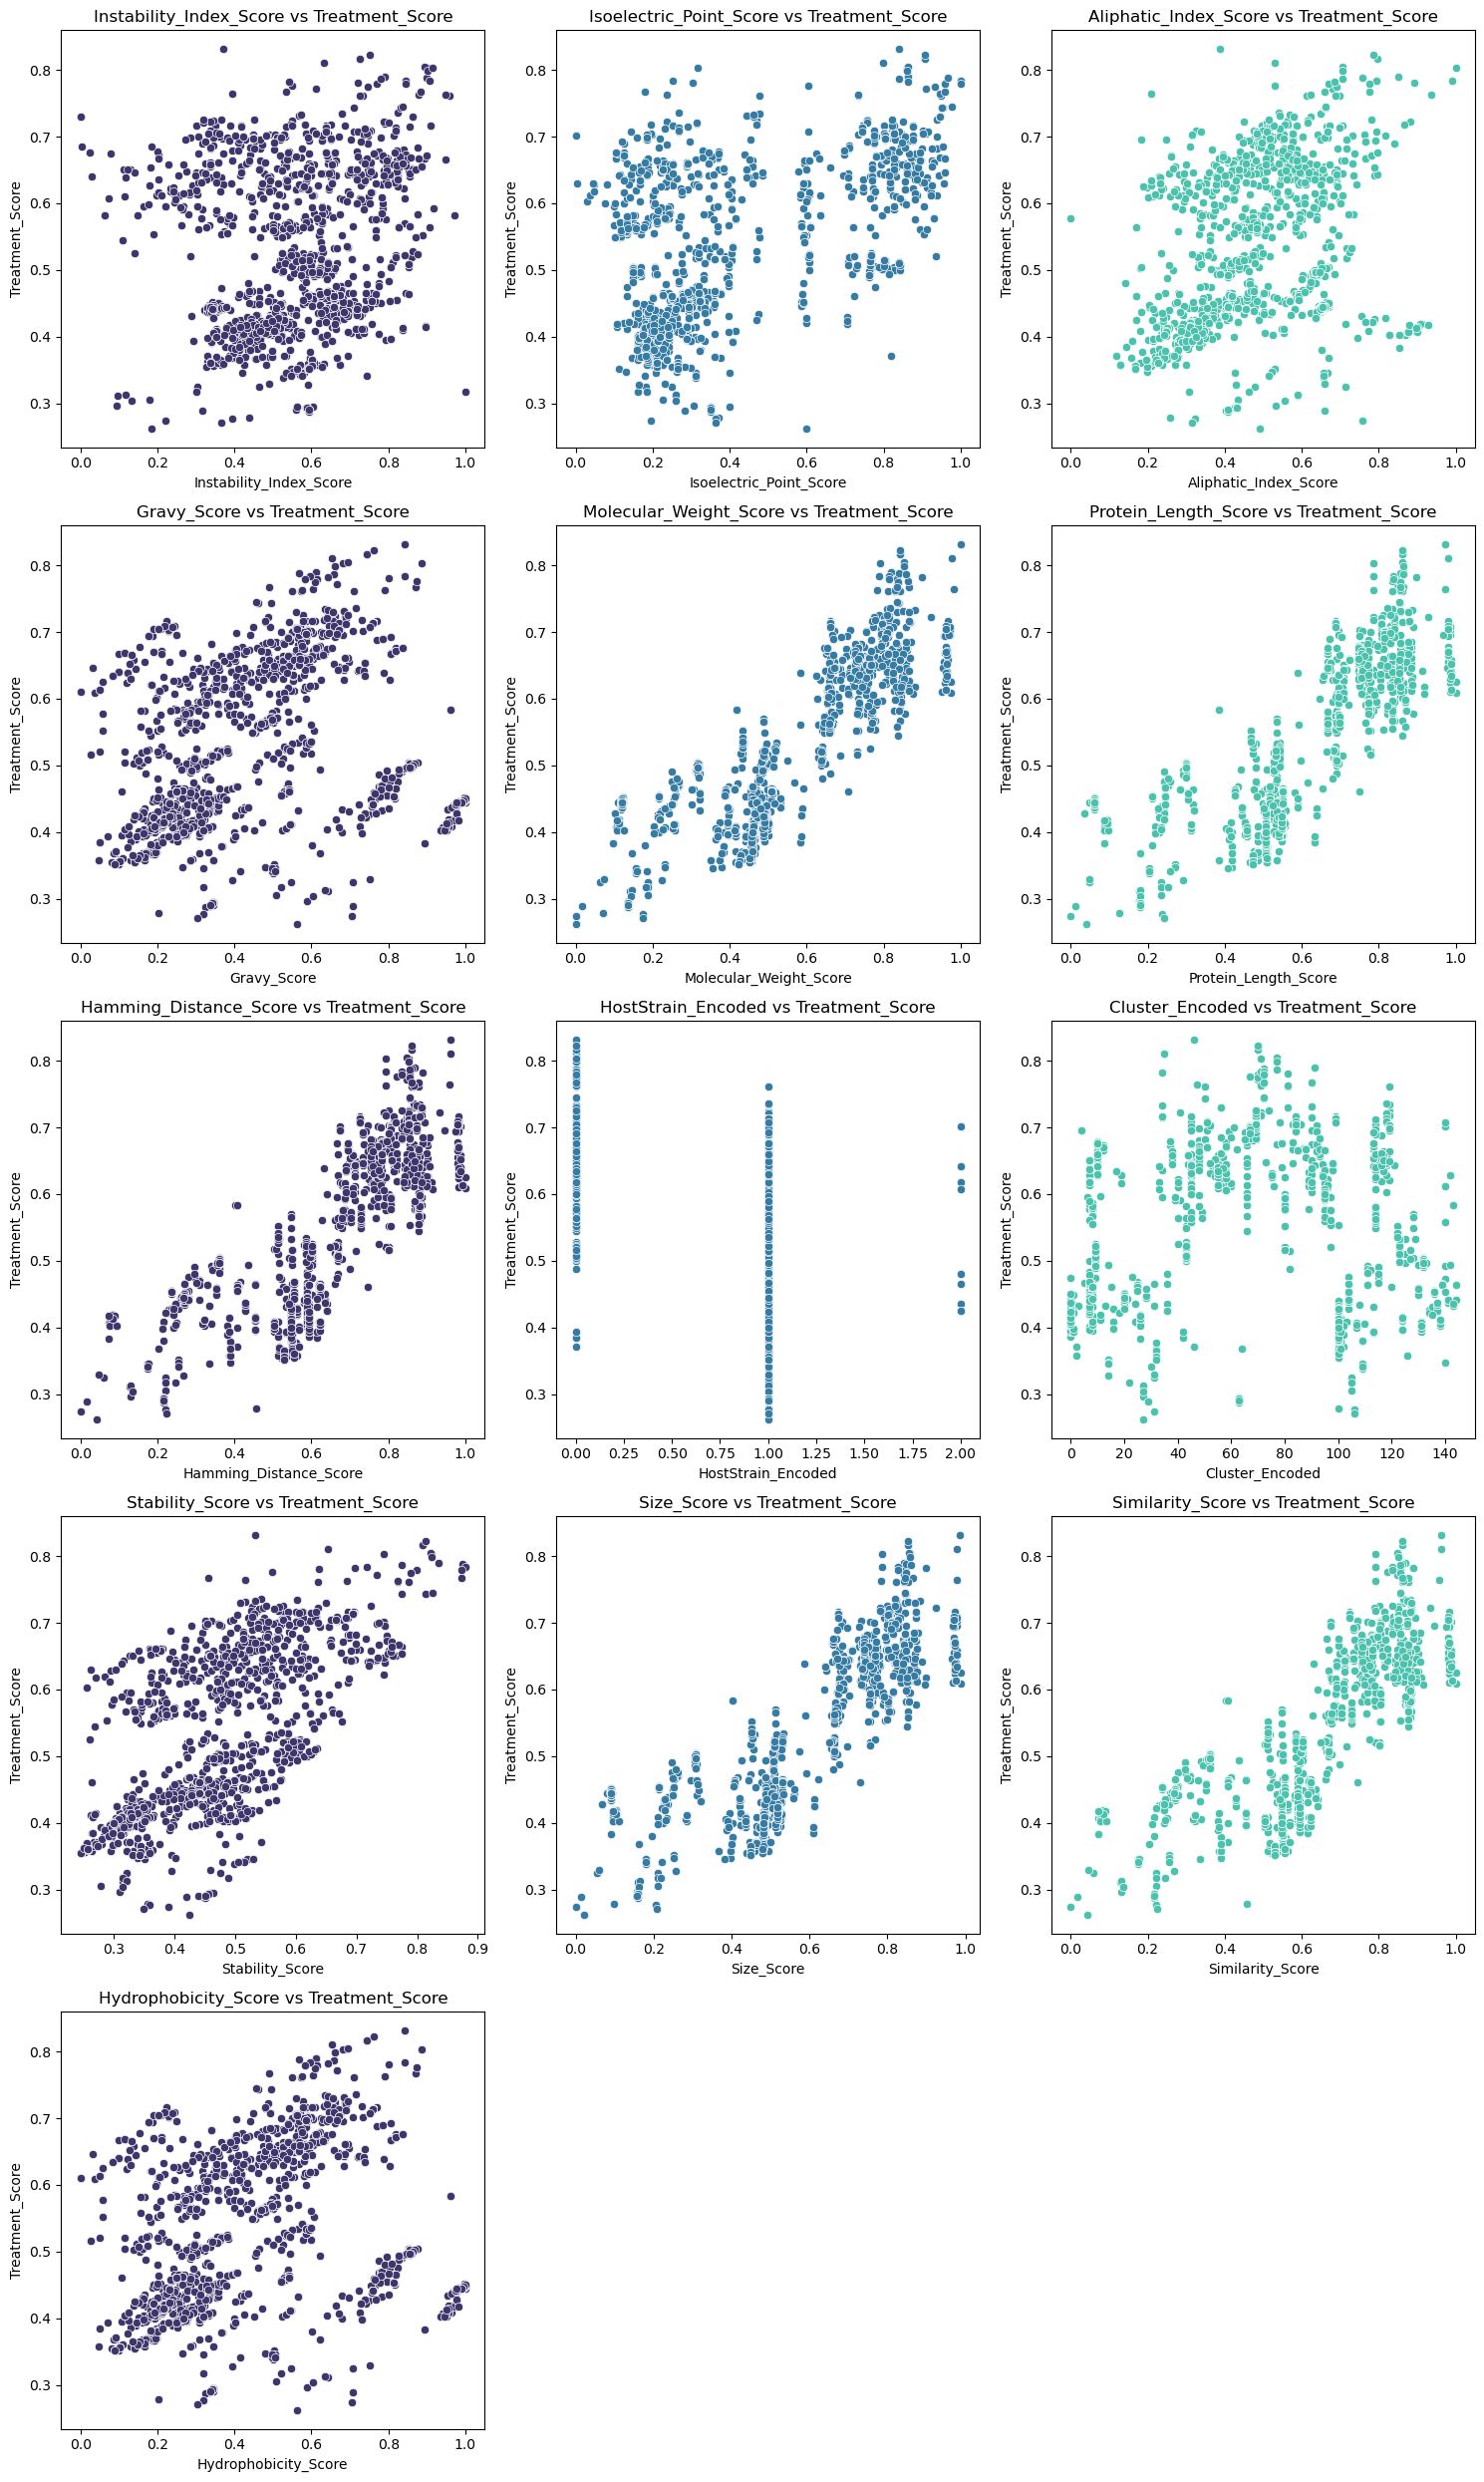

In [15]:
# List of features to plot against Treatment_Score, including the encoded features
features = [
    'Instability_Index_Score', 'Isoelectric_Point_Score', 'Aliphatic_Index_Score', 'Gravy_Score', 
    'Molecular_Weight_Score', 'Protein_Length_Score', 
    'Hamming_Distance_Score', 'HostStrain_Encoded', 'Cluster_Encoded',
    'Stability_Score', 'Size_Score', 'Similarity_Score', 'Hydrophobicity_Score',
]

# Define the number of columns for your subplot layout
n_cols = 3
n_rows = len(features) // n_cols + (len(features) % n_cols > 0)

# Set up the plotting area
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten axes array for easy iteration

# Loop through each feature and create scatter plots vs Treatment_Score
for i, feature in enumerate(features):
    sns.scatterplot(
        data=combined_lysin_b_df, 
        x=feature, 
        y='Treatment_Score', 
        ax=axes[i], 
        color=custom_palette[i % len(custom_palette)]
    )
    axes[i].set_title(f'{feature} vs Treatment_Score')

# Hide any unused subplots
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

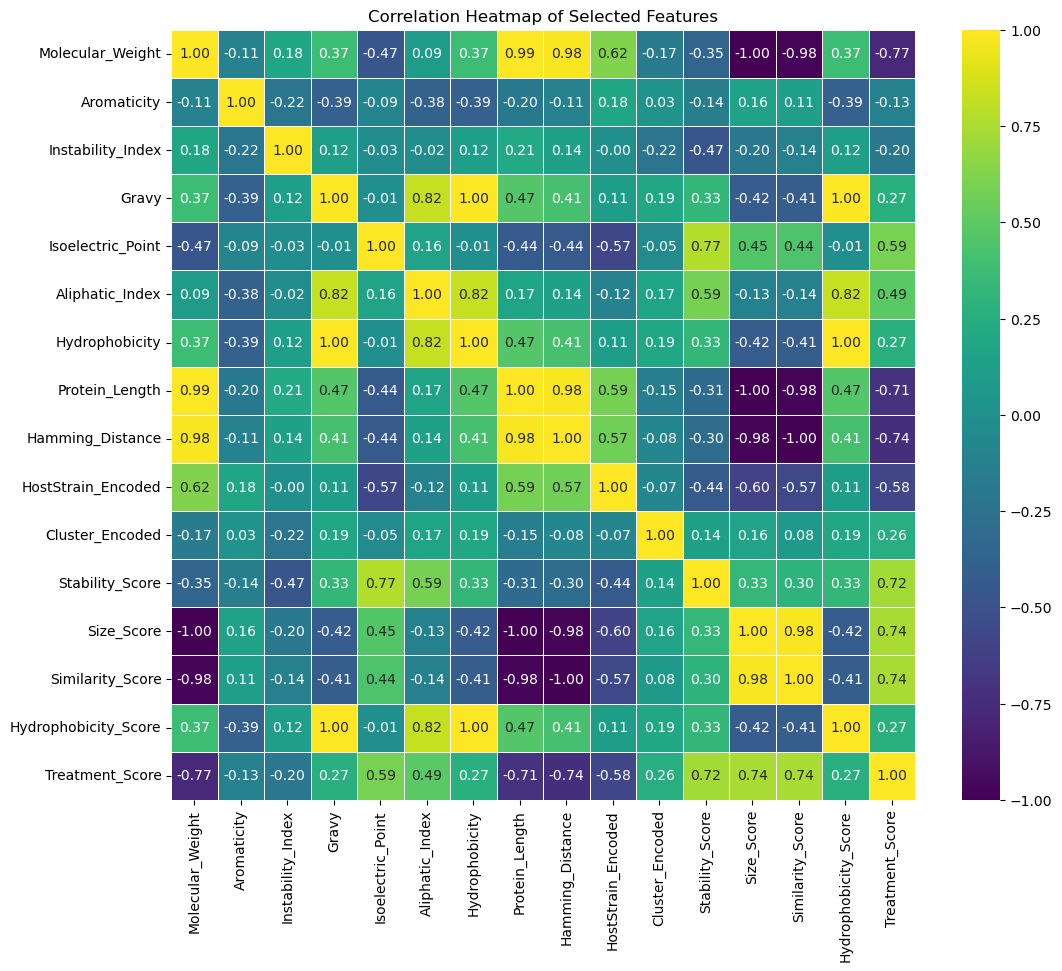

In [16]:
# Define your features, including the target 'Treatment_Score'
corr_features = ['Molecular_Weight', 'Aromaticity', 'Instability_Index', 'Gravy', 
        'Isoelectric_Point', 'Aliphatic_Index', 'Hydrophobicity', 
        'Protein_Length', 'Hamming_Distance', 'HostStrain_Encoded', 'Cluster_Encoded',
        'Stability_Score', 'Size_Score', 'Similarity_Score', 'Hydrophobicity_Score', 'Treatment_Score']

# Calculate the correlation matrix 
correlation_matrix = combined_lysin_b_df[corr_features].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="viridis", linewidths=0.5, center=0)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

In [17]:
# Extract correlations with 'Treatment_Score'
correlation_with_target = correlation_matrix['Treatment_Score'].sort_values(ascending=False)

# Display the correlation with 'Treatment_Score'
print("Correlation with Treatment_Score:\n", correlation_with_target)


Correlation with Treatment_Score:
 Treatment_Score         1.000000
Size_Score              0.739977
Similarity_Score        0.737613
Stability_Score         0.719526
Isoelectric_Point       0.589452
Aliphatic_Index         0.489980
Hydrophobicity_Score    0.271915
Gravy                   0.271915
Hydrophobicity          0.271915
Cluster_Encoded         0.255291
Aromaticity            -0.131310
Instability_Index      -0.204108
HostStrain_Encoded     -0.580546
Protein_Length         -0.706397
Hamming_Distance       -0.737613
Molecular_Weight       -0.772676
Name: Treatment_Score, dtype: float64


In [18]:
# Save the DataFrame to a JSON file with a new name
json_file_path = 'modeling_lysin_b_df.json'
combined_lysin_b_df.to_json(json_file_path, orient='records', lines=True)
print(f"DataFrame saved as JSON to {json_file_path}")

# Save the DataFrame to a CSV file with a new name
csv_file_path = 'modeling_lysin_b_df.csv'
combined_lysin_b_df.to_csv(csv_file_path, index=False)
print(f"DataFrame saved as CSV to {csv_file_path}")

DataFrame saved as JSON to modeling_lysin_b_df.json
DataFrame saved as CSV to modeling_lysin_b_df.csv
